<a href="https://colab.research.google.com/github/GJEF-hub/Test-Site/blob/master/GJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using cpu device
Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  8
The batch size for this dataset will be =  64
Class Labels:
Class 0: basophil
Class 1: eosinophil
Class 2: erythroblast
Class 3: immature granulocytes(myelocytes, metamyelocytes and promyelocytes)
Class 4: lymphocyte
Class 5: monocyte
Class 6: neutrophil
Class 7: platelet


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Using downloaded and verified file: /root/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_224.npz
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64
Epoch 1/10
----------
train Loss: 0.8603 Acc: 0.7486
val Loss: 0.5068 Acc: 0.8318

Epoch 2/10
----------
train Loss: 0.5816 Acc: 0.8117
val Loss: 0.5055 Acc: 0.8376

Epoch 3/10
----------
train Loss: 0.5586 Acc: 0.8278
val Loss: 0.3945 Acc: 0.8662

Epoch 4/10
----------
train Loss: 0.5713 Acc: 0.8315
val Loss: 0.3833 Acc: 0.8814

Epoch 5/10
----------
train Loss: 0.5532 Acc: 0.8381
val Loss: 0.5662 Acc: 0.8353

Epoch 6/10
----------
train Loss: 0.5775 Acc: 0.8368
val Loss: 0.5373 Acc: 0.8359

Epoch 7/10
----------
train Loss: 0.6062 Acc: 0.8386
val Loss: 0.3995 Acc: 0.8826

Epoch 8/10
----------
train Loss: 0.5809 Acc: 0.8440
val Loss: 0.3719 Acc: 0.8797

Epoch 9/10
----------
tr

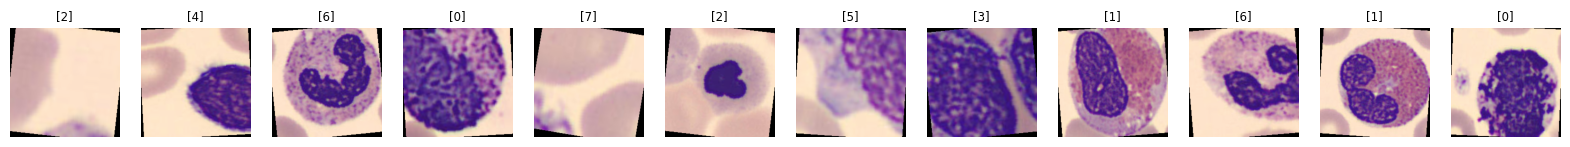

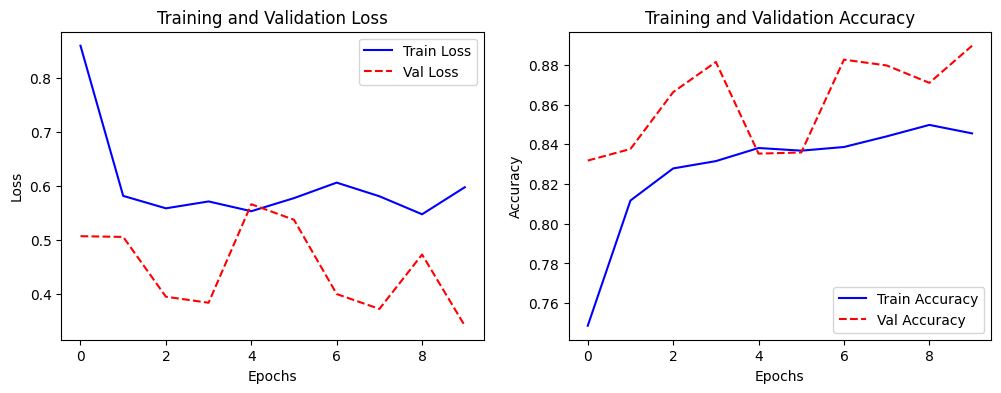

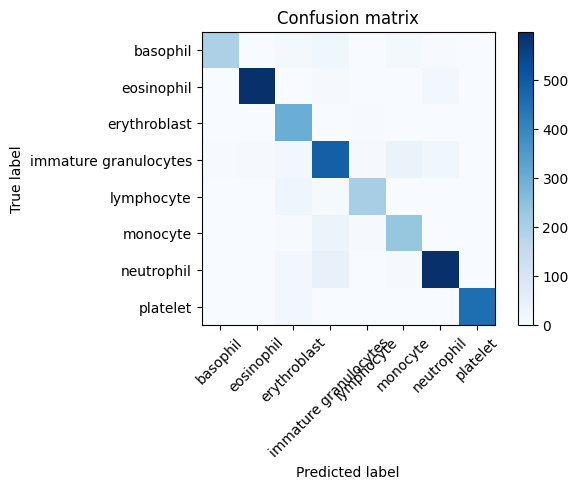

                       precision    recall  f1-score   support

             basophil       0.97      0.80      0.87       244
           eosinophil       0.98      0.95      0.97       624
         erythroblast       0.76      0.96      0.85       311
immature granulocytes       0.80      0.84      0.82       579
           lymphocyte       0.92      0.85      0.88       243
             monocyte       0.80      0.82      0.81       284
           neutrophil       0.93      0.90      0.91       666
             platelet       1.00      0.97      0.98       470

             accuracy                           0.90      3421
            macro avg       0.90      0.89      0.89      3421
         weighted avg       0.90      0.90      0.90      3421



In [1]:
!pip install medmnist
!pip install torchinfo
!pip install torch torchvision medmnist

# import libraries
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from medmnist import INFO, Evaluator
from medmnist.dataset import BloodMNIST
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import torchvision
from sklearn.metrics import classification_report
import copy
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import MNIST

import medmnist
from medmnist import INFO, Evaluator

# Define the model (assuming a pre-trained ResNet-18 model)
model = torchvision.models.resnet18(weights=True)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
model = model.to(device)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer for the specific task (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Update for 10 classes

# Only the parameters of the classifier layer will be updated.
parameters_to_update = model.fc.parameters()

# Hyperparameters
data_flag = 'bloodmnist'
download = True
LEARNING_RATE = 0.015
NUM_EPOCHS = 10
BATCH_SIZE = 64


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ', task)
print('Number of Input Data Channels = ', n_channels)
print('Number of Classes = ', n_classes)
print('The batch size for this dataset will be = ', BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

# Access and print the labels
labels = info['label']
print("Class Labels:")
for class_idx, label_name in labels.items():
    print(f"Class {class_idx}: {label_name}")

# Data augmentation and normalization for training
train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Just normalization for validation and test
test_transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')

# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1




# Define the model (assuming a pre-trained ResNet-18 model)
model = torchvision.models.resnet18(weights=True)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer for the specific task (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Update for 10 classes

# Only the parameters of the classifier layer will be updated.
parameters_to_update = model.fc.parameters()



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters_to_update, lr=LEARNING_RATE)


# Training and validation loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long().view(-1)  # Ensure labels are of type long and flatten if necessary

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, 'b', label='Train Loss')  # Blue solid line
    plt.plot(val_loss_history, 'r--', label='Val Loss')  # Red dashed line
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, 'b', label='Train Accuracy')  # Blue solid line
    plt.plot(val_acc_history, 'r--', label='Val Accuracy')  # Red dashed line
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
model = train_model(model, {'train': train_dataloader, 'val': val_dataloader}, criterion, optimizer)

# Evaluate the model on the test set
model.eval()
store_predictions = []
store_labels = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        input_batch, label_batch = data
        input_batch = input_batch.to(device)
        label_batch = label_batch.to(device).long().view(-1)  # Ensure labels are of type long and flatten if necessary

        pred_logit = model(input_batch)
        predictions = torch.argmax(pred_logit, 1)  # reduce along output dimension
        predictions_np = predictions.to('cpu').numpy()
        label_batch_np = label_batch.to('cpu').numpy()

        store_predictions.append(predictions_np)
        store_labels.append(label_batch_np)

# Flatten the lists
y_pred = np.concatenate(store_predictions)
y_true = np.concatenate(store_labels)

# Define classes
classes = [
    "basophil", "eosinophil", "erythroblast",
    "immature granulocytes", "lymphocyte",
    "monocyte", "neutrophil", "platelet"
]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes)
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=classes))


